In [31]:
from qiskit import QuantumCircuit, QuantumRegister, Aer, assemble
import numpy as np
from qiskit.visualization import plot_histogram, plot_bloch_multivector, array_to_latex

num_players = 5
player_id = 1

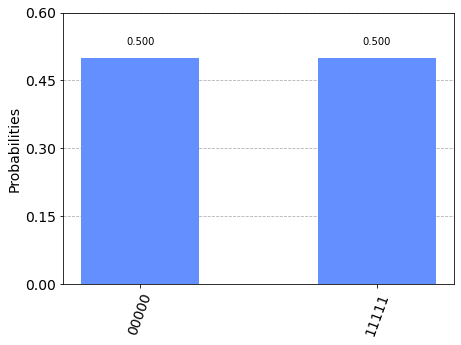

In [32]:
messages = []
coin = QuantumCircuit(num_players)

coin.h(0)

for qubit in range(num_players - 1):
    coin.cx(qubit,qubit+1)

coin.draw()

simulator = Aer.get_backend('aer_simulator')
coin.save_statevector()
state = simulator.run(assemble(coin)).result().get_statevector()

#array_to_latex(state, prefix="\\text{Statevector} = ")
plot_histogram(simulator.run(assemble(coin)).result().get_counts())

# bits = coin.qubits
# for k_player in range(num_players):
#     coin_results = [player_id, k_player, bits[k_player]]
#     messages.append(coin_results)



In [34]:
k = 3*np.log2(num_players)
num_qubits = np.around(k)
upper_bound = pow(num_players,3)

registers = [QuantumRegister]

for a in range(num_players):
    reg = QuantumRegister(num_qubits)
    registers.append(reg)

leader = QuantumCircuit(registers)
leader.draw()

#needs to represent every number from 1 to upper_bound


CircuitError: "Expected an instance of Qubit, Clbit, or AncillaQubit, but was passed QuantumRegister(7, 'q20')"